# Question 4 - [30 marks]  <a class="tocSkip"></a>

We consider an inversion problem where we are trying to find the location of the release of a pollutant that we know has been released some time $T$ ago from the south coast of a lake; We just don't know exactly where along the coast. The spread of the pollutant can be described by the following PDE

$$
\frac{\partial c(x,y,t)}{\partial t} = \kappa \nabla^2 c(x,y,t),
$$

where $c(x,y,t)$ is the concentration of the pollutant at $(x,y)$ and time $t$, and $\kappa$ is the diffusion coefficient.

For the discretisation (which you don't need to know the details of) we use the following implicit Euler time-stepping scheme

$$
  \frac{{\bf c}^{k+1} - {\bf c}^k}{\Delta t} = -\frac{\kappa}{\Delta x^2} \underline{\mathbf A} {\bf c}
$$

where $\bf c^k$ is the $n$-vector containing the discrete solution at all $n$ grid points at timestep $k$, and $\underline{\mathbf A}$ is the $n\times n$ matrix associated with the finite-difference discretisation of the Laplace operator $-\nabla^2$, for which you can use the code given below. Using the $n\times n$ identity operator $\underline{\mathbf I}$, we can write this as

\begin{equation}
  \left(\underline{\mathbf I} + \kappa \frac{\Delta t}{\Delta x^2} \underline{\mathbf A}\right) {\bf c}^{k+1}
  = {\bf c}^k \tag{1}
\end{equation}

which gives a linear system to be solved in every time-step.

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import scipy.optimize as sop
import matplotlib.pyplot as plt

def Laplace(Nx, Ny):
    """ Assembles a discrete Laplace operator with Neumann boundary conditions
    into a sparse matrix.
    """
    # construct matrix from 5 (off-)diagonals
    # we provide the diagonals as one 5 x n array
    # the actual off-diagonals should of course be shorter
    # but dia_matrix cuts them off for us
    n = Nx*Ny
    offsets = [-Nx, -1, 0, 1, Nx]
    diags = -np.ones((5,n))
    diags[2] = -diags[2]*4  # main diagonal should be positive and 4 times the off-diagonals
    A = sp.dia_matrix((diags, offsets), shape=(n,n)).tocsr()
    
    # grid point in the right-most column, should not be connected to
    # the grid point in the first column on the next row
    for i in range(1,Ny):
        A[i*Nx-1, i*Nx] = 0
        A[i*Nx, i*Nx-1] = 0
        
    # for homogenous Neumann boundary conditions all we have to do is
    # make sure that the diagonal is set such that the row sum is zero
    # This replaces some of the 4 values on the diagonal with the actual number
    # of connected grid points on the boundary:
    A.setdiag(A.diagonal() - np.array(A.sum(axis=1)).flatten())
    
    return A

**4.1** Given the fact that $\underline{\mathbf A}$ is _symmetric_ and _positive semi-definite_, what do you know about the matrix $\underline{\mathbf I}+\kappa\frac{\Delta t}{\Delta x^2}\underline{\mathbf A}$ (assuming $\kappa, \Delta t, \Delta x$ are all strictly positive)? What solver strategy would you recommend?

We assume a square lake of $L$ by $W$, and a grid of $n=N_x \times N_y$. You may use the following parameter choices:

In [2]:
# number of grid points in both directions, and total number of gridpoints
Nx = 50
Ny = 50
n = Nx*Ny

L = 2e3  # length in x-direction
dx = L/Nx  # grid spacing - assumed to be the same in both directions
W = Ny*dx  # width in y-direction

dt = 3600  # timestep size
T = 3600*24  # total run time: one day
Nt = int(T/dt)  # number of timesteps

kappa = 1  # diffusion coefficient

A = Laplace(Nx, Nx)
I = sp.eye(n)  # sparse n x n identity matrix
matrix = I + kappa*(dt/dx**2)*A

We want to study the effect of releasing the pollutant at $t=0$ in a single point somewhere along the south coast. We number the computational grid row by row, starting at the south coast at $y=0$, so the south coast itself corresponds to the first $N_x$ grid points. We will store the initial concentrations along the south coast in a length $N_x$ vector $m$. So you should initialise your model as follows:

In [3]:
m_init = np.zeros(Nx)  # initial concentrations along the south coast

# assume a release at a single grid point at e.g. x = 0.3 * L
m_init[int((0.3*L)/dx)] = 1

# set initial condition for c which is defined on the entire grid
c0 = np.zeros(n)
c0[:Nx] = m_init

You can plot any solution, or here the initial condition, as follows:

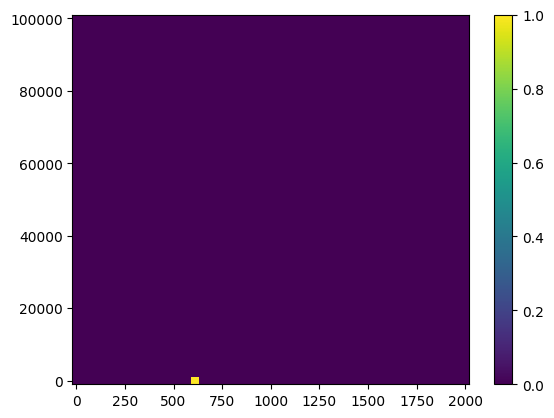

In [4]:
x = np.linspace(0, L, Nx)
y = np.linspace(0, W, Ny)

plt.pcolor(x, y, c0.reshape((Ny, Nx)))
plt.colorbar();

**4.2** Implement a time-stepping loop that performs `Nt` (defined above) timesteps, and plot the final solution at the end. Use the solver strategy you specified in the previous question. You may use any algorithm implemented in `scipy` here. Plot the final solution at time $t=T = N_t \Delta t = 1$ day.

Store the final solution in a separate array `c_target`. We now like to see if we can retrieve the original `m_init`
from this final state `c_target`, so that if we were to observe the spread of the pollutant in the form of `c_target`, we would know where along the coast it was released some time `T = Nt * dt` ago. To do this we formulate the problem as a PDE-constrained optimisation problem:

$$
\text{minimize } f({\bf c}, {\bf m}) = \tfrac 12\| {\bf c}_{\text{target}} - {\bf c}^{N_t}\|^2
$$

subject to the _discrete_ PDE constraint

$$
\newcommand\bigm{\underline{\mathbf I} + \kappa\frac{\Delta t}{\Delta x^2} \underline{\mathbf A}}
\newcommand\idt{\underline{\mathbf I}}
{\bf g}({\bf c}, {\bf m}) =
\begin{pmatrix}
\vphantom{\begin{pmatrix}{\bf m} \\ 0 \end{pmatrix}} \idt & 0 & 0 & 0 & \dots & 0 & 0  \\
-\idt & \bigm & 0 & 0 & \dots & 0  & 0 \\
0 & -\idt & \bigm & 0 & \dots & 0  & 0\\
0 & 0 & -\idt & \bigm & \dots & 0  & 0 \\
\vdots & \vdots & \vdots & \ddots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & \dots &  -\idt & \bigm & 0 \\
0 & 0 & 0 & 0 & \dots & -\idt & \bigm 
\end{pmatrix}
\begin{pmatrix}
  \vphantom\bigm {\bf c}^0 \\ \vphantom\bigm {\bf c}^1 \\ \vphantom\bigm{\bf c}^2 \\ \vphantom\bigm{\bf c}^3 \\ \vphantom\bigm\dots \\ \vphantom\bigm{\bf c}^{N_t-1} \\ \vphantom\bigm{\bf c}^{N_t}
\end{pmatrix}
-
\begin{pmatrix}
  \begin{pmatrix}{\bf m} \\ 0 \end{pmatrix} \\ \vphantom\bigm {\bf 0} \\ \vphantom\bigm{\bf 0} \\ \vphantom\bigm{\bf 0} \\ \vphantom\bigm\dots \\ \vphantom\bigm{\bf 0} \\ \vphantom\bigm{\bf 0}
\end{pmatrix} = 0
$$

Note that the first row of ${\bf g}({\bf c}, {\bf m})$:

$$
  \idt {\bf c}^0 - \begin{pmatrix}{\bf m} \\ 0 \end{pmatrix} = 0
  \quad\rightarrow\quad {\bf c}^0 = \begin{pmatrix}{\bf m} \\ 0 \end{pmatrix}
$$

simply represents the copying of the ${\bf m}$ vector of length $N_x$ into the first $N_x$ entries of ${\bf c}^0$, and zeroing the other entries. Subsequent rows represent the linear system of equations (given in eqn. (1) above question 4.1) of each time step.

We also define the associated reduced functional

$$\hat{f}({\bf m}) = f({\bf c}({\bf m}), {\bf m}),
\text{ where }{\bf c}({\bf m}) = {\bf c}
\text{ is the solution to }{\bf g}({\bf c}, {\bf m}) = 0,
$$

in other words we run the forward model using ${\bf m}$ to compute ${\bf c}$, and using its (final timestep) value compute $f$.

**4.3** Work out the adjoint equation for this discrete PDE-constrained optimisation problem, and describe how the adjoint solution vectors $\boldsymbol{\lambda}^{0}\dots \boldsymbol{\lambda}^{N_t}$ can be solved one-by-one. Work out the equations in terms of ${\bf c}_{target}$ and the solution vectors ${\bf c}^k$ of the forward model. Explain how we can compute $\frac{\partial\hat{f}({\bf m})}{\partial\bf m}$ after that.

**4.4** Implement the reduced functional `fhat(m)` which takes a length $N_x$ array `m`, runs the forward model and returns $f({\bf c}, {\bf m})$. Also implement its derivative `dfhat(m)` which takes a length $N_x$ array `m` and returns a length $N_x$ array representing the gradient of $\hat{f}$ with respect to $\bf m$. Test your implementation for correctness! **Hint**: in the test of your derivative you may need to choose tighter tolerances in the solves that you use in the timesteps.

**4.5** Use `fhat` and `dfhat` to solve the inversion problem. You may use the following code, which enforces bounds to ensure that the resulting $\bf m$ stays between 0 and 1.

In [ ]:
import scipy.optimize as sop
m = np.ones(Nx)
bounds = np.zeros((Nx, 2))
# lower bounds in the first column are zero
bounds[:,1] = 1  # upper bounds in the second column are one

result = sop.minimize(fhat, m, jac=dfhat, options={'maxiter':200, 'gtol': 1e-12}, method='l-bfgs-b', bounds=bounds)

print(result)
# this plots the recovered source vs. the original source
plt.plot(x, result['x'], label='Recovered source')
plt.plot(x, m_init, label='Original source')
plt.legend()

You may find that the recovered source is spread out quite a bit more than the original ${\bf m}$-vector. This is an example of an ill-posed problem: multiple vectors $\bf m$ may result in the same distribution of the concentration $c(x,y,t)$ after $N_t$ timesteps. Since we know that the original pollution was very much concentrated in a single place we would like to penalize solutions that are more spread out. Our usual trick of penalising the norm of $\bf m$, does not work here: the solution `m` you find through the inversion process, will integrate (sum) to approximately the same value as the true source `m_init`, but the more spread out the smaller the norm will be; For example, if the true source has a value of 1 in just one grid point, but the recovered source has a value of $1/4$ in 4 grid points, then the norm of the recovered source is smaller: $\sqrt{{\tfrac 14}^2 + {\tfrac 14}^2 + {\tfrac 14}^2 + {\tfrac 14}^2}\lt 1$. So instead we want to do the reverse: penalise solutions with a small norm! This is possible here because the noisy oscillatory modes that would otherwise pollute the solution (and be encouraged by our penalty term!) are already kept in hand by the imposed bounds. Therefore we want to change the functional to

$$
  f({\bf c}, {\bf m}) = \tfrac 12\| {\bf c}_{\text{target}} - {\bf c}^{N_t}\|^2 + \frac{\mu}{1 + \|{\bf m}\|^2},
$$

where $\mu$ is a user chosen parameter (suggested value $\mu=10^{-4}$).

**4.6** Extend the reduced functional, and its derivative, to include the new penalty term. Don't forget to test the derivative! Now see if you can get a solution to the inverse problem that is closer to the original source.